In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install opencv-python-headless pandas

In [3]:
pip install matplotlib

In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [5]:
import os
import pandas as pd
import cv2

# === Define Paths ===
csv_path = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/Licplatesdetection_train.csv"
image_dir = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/license_plates_detection_train/images"
label_dir = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/license_plates_detection_train/labels"
os.makedirs(label_dir, exist_ok=True)

# === Read the CSV ===
df = pd.read_csv(csv_path)

# === Generate YOLOv8 Label Files ===
for img_id in df['img_id'].unique():
    img_path = os.path.join(image_dir, img_id)
    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        continue

    # Read image to get dimensions
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Cannot read image: {img_path}")
        continue
    height, width = img.shape[:2]

    # Get all boxes for this image
    rows = df[df['img_id'] == img_id]

    # Write label file (same name as image, but with .txt extension)
    label_filename = os.path.splitext(img_id)[0] + ".txt"
    label_path = os.path.join(label_dir, label_filename)

    with open(label_path, 'w') as f:
        for _, row in rows.iterrows():
            x_center = ((row['xmin'] + row['xmax']) / 2) / width
            y_center = ((row['ymin'] + row['ymax']) / 2) / height
            box_width = (row['xmax'] - row['xmin']) / width
            box_height = (row['ymax'] - row['ymin']) / height
            f.write(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

print("✅ All YOLO label files created successfully.")

✅ All YOLO label files created successfully.


In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# === 1. Define paths ===
base_dir = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/license_plates_detection_train"
img_dir = os.path.join(base_dir, "images")
lbl_dir = os.path.join(base_dir, "labels")

# === 2. Rename images to match labels ===
images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
labels = sorted([f for f in os.listdir(lbl_dir) if f.endswith(".txt")])

if len(images) != len(labels):
    raise ValueError(f"Mismatch: {len(images)} images vs {len(labels)} labels")

for i, lbl_name in enumerate(labels):
    index = os.path.splitext(lbl_name)[0]  # e.g., "1"
    new_img_name = f"{index}.jpg"
    old_img_path = os.path.join(img_dir, images[i])
    new_img_path = os.path.join(img_dir, new_img_name)
    os.rename(old_img_path, new_img_path)

print("✅ Renamed image files to match label files.")

# === 3. Split images ===
images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
train_files, val_files = train_test_split(images, test_size=0.2, random_state=42)

split_base = "/content/split_data"
train_img = os.path.join(split_base, "train/images")
train_lbl = os.path.join(split_base, "train/labels")
val_img = os.path.join(split_base, "val/images")
val_lbl = os.path.join(split_base, "val/labels")

for d in [train_img, train_lbl, val_img, val_lbl]:
    os.makedirs(d, exist_ok=True)

def copy_files(file_list, src_img, src_lbl, dst_img, dst_lbl):
    for f in file_list:
        shutil.copy(os.path.join(src_img, f), os.path.join(dst_img, f))
        label = f.replace(".jpg", ".txt")
        src_label_path = os.path.join(src_lbl, label)
        dst_label_path = os.path.join(dst_lbl, label)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
        else:
            print(f"⚠️ Skipping: No label found for {f}")

copy_files(train_files, img_dir, lbl_dir, train_img, train_lbl)
copy_files(val_files, img_dir, lbl_dir, val_img, val_lbl)

print("✅ Split complete: train and val folders created.")

# === 4. Write data.yaml ===
yaml_path = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/data.yaml"
with open(yaml_path, "w") as f:
    f.write(f"""
path: {split_base}
train: train/images
val: val/images
nc: 1
names: ['license_plate']
""".strip())

print(f"✅ data.yaml created at: {yaml_path}")

# === 5. Train YOLOv8 ===
model = YOLO("yolov8n.pt")  # Change to 'yolov8s.pt' for better accuracy

model.train(
    data=yaml_path,
    epochs=20,
    imgsz=640,
    batch=16,
    project="/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT",
    name="plate_detector_v2",
    exist_ok=True
)

print("✅ Training complete. Model saved in 'plate_detector_v2'.")

✅ Renamed image files to match label files.
✅ Split complete: train and val folders created.
✅ data.yaml created at: /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/data.yaml
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, 

train: Scanning /content/split_data/train/labels.cache... 748 images, 1 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 384.5±192.7 MB/s, size: 114.9 KB)


val: Scanning /content/split_data/val/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.19G      1.233      2.408       1.12         29        640: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


                   all        180        180          1      0.081      0.883      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.69G      1.149      1.407      1.015         23        640: 100%|██████████| 47/47 [00:14<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


                   all        180        180      0.956      0.723      0.922      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.69G      1.173      1.208      1.025         30        640: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


                   all        180        180      0.942      0.908      0.964      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.69G      1.101      1.044      1.005         20        640: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        180        180       0.96      0.936      0.954      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.69G      1.098     0.9269      1.009         24        640: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        180        180      0.941      0.972      0.988      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.69G      1.083     0.8548     0.9975         21        640: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


                   all        180        180      0.978      0.978      0.992       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.69G      1.006     0.7532      0.968         32        640: 100%|██████████| 47/47 [00:14<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


                   all        180        180      0.983      0.985       0.99      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.69G      1.059     0.7394     0.9795         17        640: 100%|██████████| 47/47 [00:14<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        180        180      0.951      0.974       0.97      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.69G      1.023     0.6989      0.987         29        640: 100%|██████████| 47/47 [00:14<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        180        180      0.984      0.994      0.995      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.69G     0.9974     0.6599     0.9509         29        640: 100%|██████████| 47/47 [00:14<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        180        180      0.994      0.977      0.995      0.733


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.69G     0.9591     0.6474     0.9561         13        640: 100%|██████████| 47/47 [00:16<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        180        180      0.978      0.989      0.994      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.69G     0.9207     0.5963     0.9364         13        640: 100%|██████████| 47/47 [00:14<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        180        180      0.982      0.994       0.99      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.69G     0.8913     0.5774      0.935         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        180        180      0.978       0.98      0.994      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.69G     0.8782      0.554     0.9276         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        180        180      0.993      0.994      0.995      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.69G     0.8631      0.535     0.9221         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        180        180      0.987      0.994      0.994      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.69G     0.8621     0.5215     0.9269         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        180        180      0.992      0.994      0.995      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.69G     0.8379     0.4965     0.9081         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


                   all        180        180      0.998      0.989      0.995      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.69G     0.8248     0.4853     0.9007         13        640: 100%|██████████| 47/47 [00:14<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        180        180      0.994      0.998      0.995      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.69G     0.7786     0.4581     0.8871         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        180        180      0.995          1      0.995      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.69G      0.768     0.4433     0.8945         13        640: 100%|██████████| 47/47 [00:13<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        180        180      0.994          1      0.995      0.807



20 epochs completed in 0.093 hours.
Optimizer stripped from /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


                   all        180        180      0.994          1      0.995      0.807
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2
✅ Training complete. Model saved in 'plate_detector_v2'.


🖼️ Image selected: 1035.jpg

image 1/1 /content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/Images/1035.jpg: 640x480 1 license_plate, 13.1ms
Speed: 3.3ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


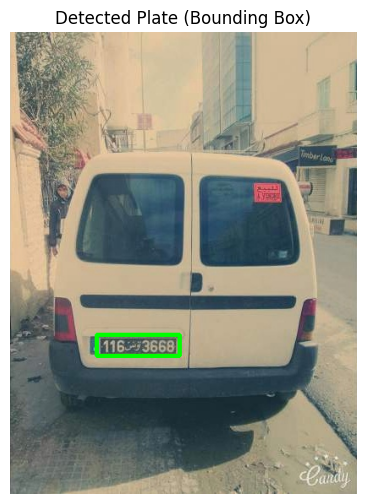

In [19]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
yolo_model = YOLO("/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/plate_detector_v2/weights/best.pt")

# Choose random test image
test_img_dir = "/content/drive/MyDrive/DATA_SCIENTIST_ASSIGNMENT/test/Images"
random_img = random.choice(os.listdir(test_img_dir))
img_path = os.path.join(test_img_dir, random_img)
print(f"🖼️ Image selected: {random_img}")

# Run detection
results = yolo_model(img_path)
boxes = results[0].boxes.xyxy.cpu().numpy()

# Load image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw bounding box
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
    break  # only the first detection

# Show image with box
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Detected Plate (Bounding Box)")
plt.show()